100%|██████████| 6000/6000 [00:01<00:00, 4495.95it/s]


test loss: 0.0011740332702174783


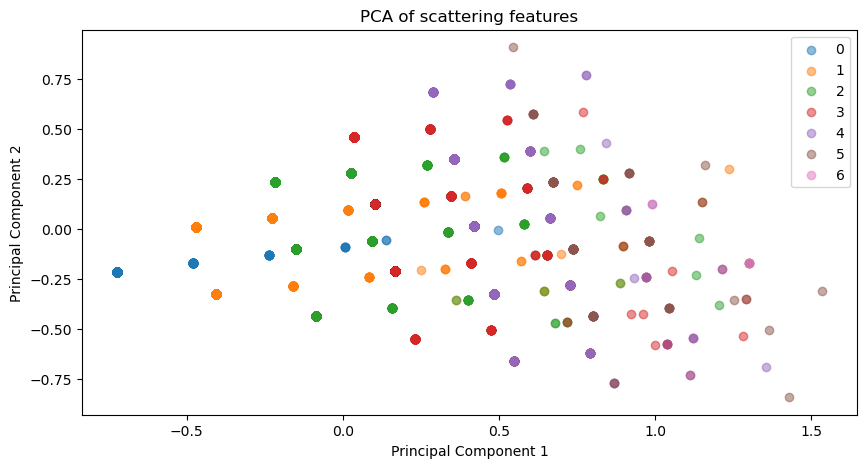

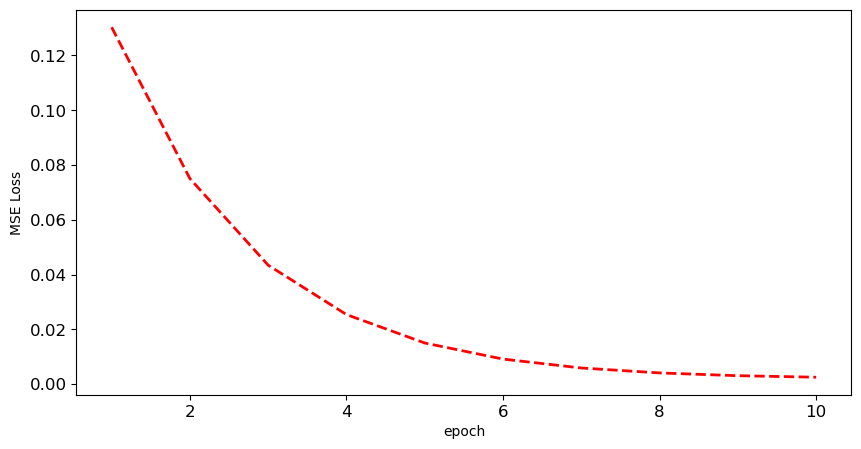

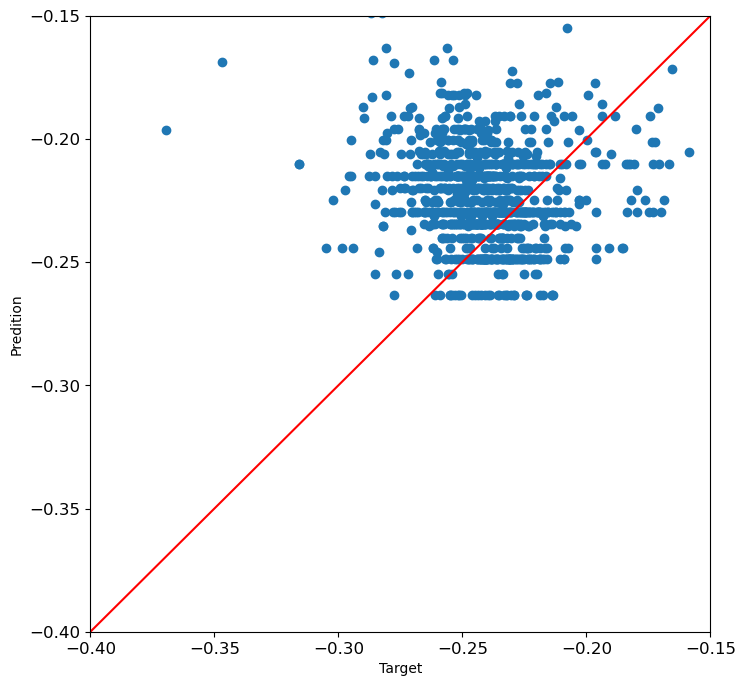

In [3]:
"""
ACMS 80770-03: Deep Learning with Graphs
Instructor: Navid Shervani-Tabar
Fall 2022
University of Notre Dame

Homework 4: Programming assignment
Problem 2
"""
import torch
import warnings
import numpy as np
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=UserWarning)

from torch import nn
from rdkit import Chem
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from chainer_chemistry import datasets
from chainer_chemistry.dataset.preprocessors.ggnn_preprocessor import GGNNPreprocessor


# -- load data
class MolecularDataset(Dataset):
    def __init__(self, N, train=True):
        if train:
            start, end = 0, 100000
        else:
            start, end = 100000, 130000


        dataset, dataset_smiles = datasets.get_qm9(GGNNPreprocessor(kekulize=True),
                                                   return_smiles=True,
                                                   target_index=np.random.choice(range(133000)[start:end], N, False))

        self.atom_types = [6, 8, 7, 9, 1]
        self.V = 9

        self.adjs = torch.stack(list(map(self.adj, dataset)))
        self.sigs = torch.stack(list(map(self.sig, dataset)))
        self.prop = torch.stack(list(map(self.target, dataset)))[:, 5]
        self.prop_2 = torch.stack(list(map(self.target_2, dataset_smiles)))

    def target_2(self, smiles):
        """
            compute the number of hydrogen-bond acceptor atoms
        :param smiles: smiles molecular representation
        :return:
        """
        mol = Chem.MolFromSmiles(smiles)

        return torch.tensor(Chem.rdMolDescriptors.CalcNumHBA(mol))

    def adj(self, x):
        x = x[1]
        adjacency = np.zeros((self.V, self.V)).astype(float)
        adjacency[:len(x[0]), :len(x[0])] = x[0] + 2 * x[1] + 3 * x[2]
        return torch.tensor(adjacency)

    def sig(self, x):
        x = x[0]
        atoms = np.ones((self.V)).astype(float)
        atoms[:len(x)] = x
        out = np.array([int(atom == atom_type) for atom_type in self.atom_types for atom in atoms]).astype(float)
        return torch.tensor(out).reshape(5, len(atoms)).T

    def target(self, x):
        """
            return Highest Occupied Molecular Orbital (HOMO) energy
        :param x:
        :return:
        """
        x = x[2]
        return torch.tensor(x)

    def __len__(self):
        return len(self.adjs)

    def __getitem__(self, item):
        return self.adjs[item], self.sigs[item], self.prop[item], self.prop_2[item]


class kernel:
    def __init__(self, K, R, d, J, lamb_max):
        # -- filter properties
        self.R = float(R)
        self.J = J
        self.K = K
        self.d = d
        self.lamb_max = torch.tensor(lamb_max)

        # -- Half-Cosine kernel
        self.a = torch.tensor(self.R)*torch.log(self.lamb_max)/(self.J-self.R+1)
    
    #define the g hat function
    def g_hat(self,lamb):
        res = torch.tensor(0.)
        for k in range(self.K+1):
            if (lamb>-1*self.a) and (lamb<=0):
                res += self.d[k]*torch.cos(2*torch.pi*k*(lamb/self.a+0.5))
        return res 


    def wavelet(self, lamb, j):
        """
            constructs wavelets ($j\in [2, J]$).
        :param lamb: eigenvalue (analogue of frequency)
        :param j: filter index in the filter bank.
        :return: filter response to input eigenvalues.
        """
        return self.g_hat(torch.log(lamb)-self.a*(j-1)/self.R)

    def scaling(self, lamb):
        """
            constructs scaling function (j=1).
        :param lamb: eigenvalue (analogue of frequency).
        :return: filter response to input eigenvalues.
        """
        sum = torch.tensor(0.)
        for k in range(self.K+1):
          sum += self.R/2*self.d[k]**2
        sum += self.R*self.d[0]**2
        for j in range(2,self.J+1):
          sum -= self.wavelet(lamb,j)**2
        
        return torch.sqrt(sum)


class scattering(nn.Module):
    def __init__(self, J, L, V, d_f, K, d, R, lamb_max):
        super(scattering, self).__init__()

        # -- graph parameters
        self.n_node = V
        self.n_atom_features = d_f

        # -- filter parameters
        self.K = K
        self.d = d
        self.J = J
        self.R = R
        self.lamb_max = lamb_max
        self.filters = kernel(K=1, R=3, d=[0.5, 0.5], J=8, lamb_max=2)

        # -- scattering parameters
        self.L = L

    def compute_spectrum(self, W):
        """
            Computes eigenvalues of normalized graph Laplacian.
        :param W: tensor of graph adjacency matrices.
        :return: eigenvalues of normalized graph Laplacian
        """

        # -- computing Laplacian
        # L = ...
        L = torch.diag_embed(W.sum(1))

        # -- normalize Laplacian
        diag = W.sum(1)
        dhalf = torch.diag_embed(1. / torch.sqrt(torch.max(torch.ones(diag.size()), diag)))
        # L = ...
        L = dhalf@L@dhalf

        # -- eig decomposition
        # E, V = torch.symeig(L, eigenvectors=True)
        #
        # return abs(E), V
        E, V = torch.symeig(L, eigenvectors=True)
        return abs(E), V

    def filtering_matrices(self, W):
        """
            Compute filtering matrices (frames) for spectral filters
        :return: a collection of filtering matrices of each wavelet kernel and the scaling function in the filter-bank.
        """

        filter_matrices = []
        E, V = self.compute_spectrum(W)

        # -- scaling frame
        E_scaled = torch.diag_embed(torch.stack(list(map(self.filters.scaling, E)))).double()
        filter_matrices.append(V@E_scaled@V.T)

        # -- wavelet frame
        for j in range(2, self.J+1):
            E_wavelet = torch.diag_embed(torch.stack(list(map(self.filters.wavelet, E,[j]*len(E))))).double()
            filter_matrices.append(V@E_wavelet@ V.T)

        return torch.stack(filter_matrices) #8*9*9

    def forward(self, W, f):
        """
            Perform wavelet scattering transform
        :param W: tensor of graph adjacency matrices.
        :param f: tensor of graph signal vectors.
        :return: wavelet scattering coefficients
        """

# -- filtering matrices, 8*9*9
        g = self.filtering_matrices(W)

        # --
        U_ = [f]

        # -- zero-th layer
        S = f.mean(0)  # S_(0,1)

        for l in range(self.L):
            U = U_.copy()
            U_ = []

            for f_ in U: # [g1f,...,g8f]
                for g_j in g:

                    U_.append(abs(g_j@f_)) # [g1f,...,g8f]

                    # -- append scattering feature S_(l,i)
                    S = torch.cat((S,  U_[-1].mean(0)))
        #print(len(U_))
        return S #5*(1+8+8*8) = 365

# -- initialize scattering function
scat = scattering(L=2, V=9, d_f=5, K=1, R=3, d=[0.5, 0.5], J=8, lamb_max=2)

# -- load data
data = MolecularDataset(N=6000)

# -- Compute scattering feature maps
data_scat = torch.stack(list(map(scat.forward, data.adjs,data.sigs)))
# -- PCA projection
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
data_scat_numpy = data_scat.numpy()
# Create a PCA object with 2 components
pca = PCA(n_components=2)

# Fit the PCA model to the data
pca.fit(data_scat_numpy )

# Transform the data using the PCA model
transformed_data = pca.transform(data_scat_numpy )

# -- plot feature space

fig, ax = plt.subplots(figsize=(10, 5))
target_names = [0,1,2,3,4,5,6]

lw = 1

for i, target_name in zip(target_names, target_names):
    plt.scatter(
        transformed_data[data.prop_2 == i, 0], transformed_data[data.prop_2 == i, 1], alpha=0.5, lw=lw, label=target_name
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of scattering features")

import torch
from torch import nn
from torch import optim

# Define the neural network
class TwoLayerNet(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()

        # Define two linear layers
        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        # Forward 
        x = self.fc2(torch.relu(self.fc1(x)))
        return x

# Instantiate the neural network
model = TwoLayerNet(data_scat.shape[1], 25, 1)


"""
    Train
"""
"""
    Train
"""
# -- Initialize the model, loss function, and the optimizer
data_scat = data_scat.float()
MyLoss = nn.MSELoss()
MyOptimizer = optim.SGD(model.parameters(),lr=0.001)
#MyOptimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5, nesterov=True)
loss_epoch = []
batch_size = 64

# -- update parameters
for epoch in range(10):
    indices = torch.randperm(5000)
    x = data_scat[indices]
    y = data.prop[indices]
    cum_loss = 0
    
    for i in range(0, 5000, batch_size):

        # -- predict
        MyOptimizer.zero_grad()
        
        pred = model(x[i:(i+batch_size)])
        labels = y[i:i+batch_size]

        # -- loss
        loss = MyLoss(pred,labels)
        
        # -- optimize
        loss.backward()
        MyOptimizer.step()
        
        cum_loss += loss.item()
    
    loss_epoch.append(cum_loss/40)
    #print(f'Loss: {cum_loss/10}')


# -- plot loss
X = np.arange(1,11)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(X, loss_epoch,'r--', lw=2)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('epoch')
ax.set_ylabel('MSE Loss')

# -- Evaluation
pred = model(data_scat[5000:])
labels = data.prop[5000:]
print(f'test loss: {MyLoss(pred,labels)}')
pred = pred.detach().numpy()
labels = labels.detach().numpy()
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(labels, pred,alpha=1.0)
x = np.linspace(-0.40,-0.15,100)
y = x
ax.plot(x,y,color='r')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Target')
ax.set_ylabel('Predition')
ax.set_ylim([-0.40,-0.15]);
ax.set_xlim([-0.40,-0.15]);

